In [109]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
#import plotly.graph_objects as go

from ncon_jax import ncon
#from tensornetwork.ncon_interface import ncon
from doDMRG_MPO_comm_real2_jax2 import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *
import jax

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [110]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [111]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [112]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [113]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [114]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [115]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [116]:
def ground_state():
    #print('h =',h)
    global chi
    
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    c=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    c.append(-2)
    
    M1=[]
    for i in range(N):
        M1.append(MM1)
    Marr.append(M1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    c.append(1)
    
    M2=[]
    for i in range(N):
        M2.append(MM2)
    Marr.append(M2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    c.append(1)
    
    M3=[]
    for i in range(N):
        M3.append(MM3) 
    Marr.append(M3)
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ
    
    ML4 = np.ones((1,1,1))
    MR4 = np.ones((1,1,1))
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk4 = np.zeros((1,1,4,4))
    Mbulk4[0,0,:,:] = np.eye(4)
    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(1,1,chid,chid)
    c.append(-2)
    
    M4=[]
    for i in range(N-1):
        M4.append(Mbulk4)
    M4.append(MM4)
    Marr.append(M4)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk5 = Mbulk4
    MM5 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(1,1,chid,chid)
    c.append(1)
    
    M5=[]
    for i in range(N-1):
        M5.append(Mbulk5)
    M5.append(MM5)
    Marr.append(M5)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk6 = Mbulk4
    MM6 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(1,1,chid,chid)
    c.append(1)
    
    M6=[]
    for i in range(N-1):
        M6.append(Mbulk6)
    M6.append(MM6)
    Marr.append(M6)
    
    
    
    Mbulk7 = ncon([iden,iden],[[-1,-2],[-3,-4]]).reshape(1,1,chid,chid)
    MLarr.append(ML4)
    MRarr.append(MR4)
    c.append(100)
    
    M7=[]
    for i in range(N):
        M7.append(Mbulk7)
    Marr.append(M7)
    
    
    
    
    
    
    
    chi = 4
    
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))
    
    En=[]
    
    
    
    for i in range(3):
        
        OPTS_numsweeps1 = 50
        
        #### Do DMRG sweeps (2-site approach)
        Enn1, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,chi, numsweeps = OPTS_numsweeps1, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        #print('Minimal value of the functional: ', np.real(Enn[-1]))
        #print(Enn)
        print()
        En.append(Enn1)
        printentrlocsvd(sWeight)
    
    
        OPTS_numsweeps2 = 50
    
        #### Do DMRG sweeps (2-site approach)
        Enn2, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,chi, numsweeps = OPTS_numsweeps2, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        print('Minimal value of the functional: ', np.real(Enn2[-1]))
        #print(Enn)
        print()
        En.append(Enn2)
        printentrlocsvd(sWeight)
        
        
        plotminfuncofnumsweep(np.concatenate([Enn1,Enn2]), OPTS_numsweeps1+OPTS_numsweeps2)
    
    
        chi *= 2

    
    return (En[-1][-1],A)

In [117]:
def plotminfuncofnumsweep(Enn, OPTS_numsweeps):
    t = np.arange(OPTS_numsweeps)
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, Enn, 'bs', label="Minimal value of the functional")
    plt.xlabel("Sweep number", fontsize=20)
    plt.ylabel("Minimal value of the functional", fontsize=20)
    plt.axis('tight')
    plt.show()

In [118]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [119]:
def printentrlocdensmatr(m):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        print('Position = ', i,': ',entrloc[i])
    
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'bs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [120]:
def printentrlocsvd(sWeight):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    print()
    for i in range(N//2,N//2+1):
        #matr = m[i].reshape(m[i].shape[0]*m[i].shape[1],m[i].shape[2])
        #u,s,vh = LA.svd(matr,full_matrices=False)
        s = np.diag(sWeight[i])
        summ = 0
        for j in range(len(s)):
            mod2 = s[j]*np.conj(s[j])
            summ -= mod2 * np.log(mod2)
        entrloc.append(summ)
        print('Position = ', i-1,': ',entrloc[0])
        print()
        for j in range(len(s)):
            print('Lambda_i =',s[j])
        tt = np.arange(len(s))
        fff = plt.figure(figsize=(18, 10))
        plt.plot(tt, s, 'bs', label="Lambda_i")
        plt.xlabel("i", fontsize=20)
        plt.ylabel("Lambda_i", fontsize=20)
        plt.axis('tight')
        plt.show()
    
    '''
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'rs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    '''

In [121]:
def CalculateEnergy():
    global h
    global g
    global N
    g=1.05
    print('g =',g)
    print('h =',h)
    print()
    E=[]
    for N in range(10,11):
        print('The length of the Ising spin chain N =',N)
        Ecur, A = ground_state()
        print('Mininimal value of the functional')
        print(np.around(np.real(Ecur),decimals=acc))
        print()
        E.append(np.around(np.real(Ecur),decimals=acc))
        
        
        
    """
    t=np.arange(8,9)
    
    #fig = go.Figure(data=[go.Table(header=dict(values=['h', 'Energy']),
                 #cells=dict(values=[t, E]))
                     #])
    #fig.show()
    
    
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, E, 'bs')
    plt.legend()
    plt.xlabel("The length of the Ising spin chain N", fontsize=20)
    plt.ylabel("Mininimal value of the functional", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    """

In [122]:
tn.set_default_backend("jax")

H = - ZZ + hZ + gX
g = 1.05
h = 0.1

The length of the Ising spin chain N = 10
Sweep: 1 of 50, Energy: 0.541100, Bond dim: 4
Sweep: 2 of 50, Energy: 0.341120, Bond dim: 4
Sweep: 3 of 50, Energy: 0.252043, Bond dim: 4
Sweep: 4 of 50, Energy: 0.188426, Bond dim: 4
Sweep: 5 of 50, Energy: 0.140334, Bond dim: 4
Sweep: 6 of 50, Energy: 0.109233, Bond dim: 4
Sweep: 7 of 50, Energy: 0.091872, Bond dim: 4
Sweep: 8 of 50, Energy: 0.079376, Bond dim: 4
Sweep: 9 of 50, Energy: 0.070938, Bond dim: 4
Sweep: 10 of 50, Energy: 0.064353, Bond dim: 4
Sweep: 11 of 50, Energy: 0.059374, Bond dim: 4
Sweep: 12 of 50, Energy: 0.055526, Bond dim: 4
Sweep: 13 of 50, Energy: 0.052245, Bond dim: 4
Sweep: 14 of 50, Energy: 0.049577, Bond dim: 4
Sweep: 15 of 50, Energy: 0.047267, Bond dim: 4
Sweep: 16 of 50, Energy: 0.045231, Bond dim: 4
Sweep: 17 of 50, Energy: 0.043405, Bond dim: 4
Sweep: 18 of 50, Energy: 0.041674, Bond dim: 4
Sweep: 19 of 50, Energy: 0.040107, Bond dim: 4
Sweep: 20 of 50, Energy: 0.038720, Bo

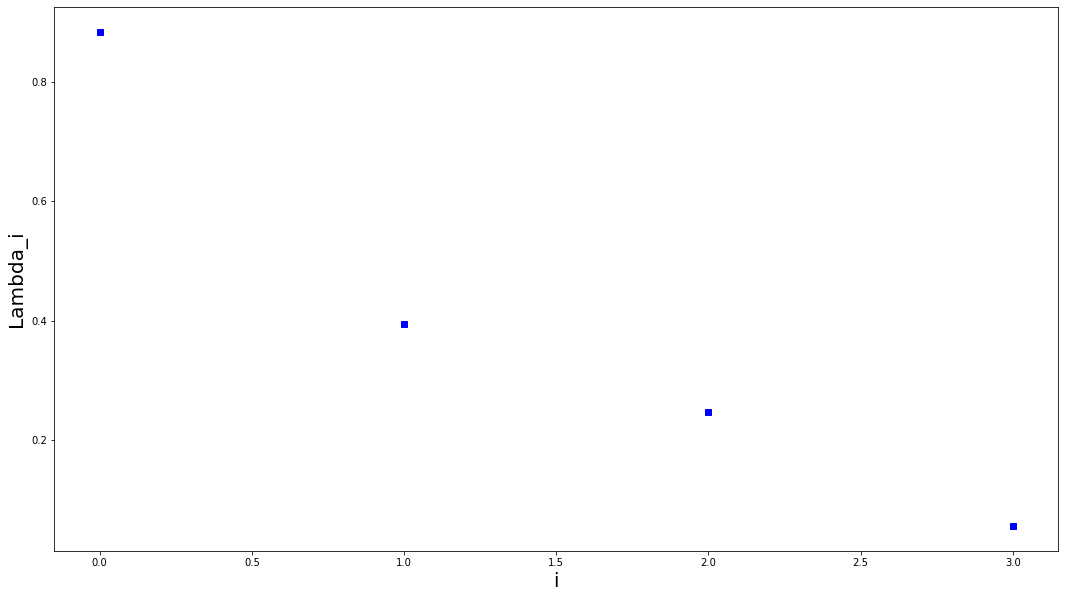

Sweep: 1 of 50, Energy: 0.021812, Bond dim: 4
Sweep: 2 of 50, Energy: 0.021605, Bond dim: 4
Sweep: 3 of 50, Energy: 0.021407, Bond dim: 4
Sweep: 4 of 50, Energy: 0.021219, Bond dim: 4
Sweep: 5 of 50, Energy: 0.021040, Bond dim: 4
Sweep: 6 of 50, Energy: 0.020870, Bond dim: 4
Sweep: 7 of 50, Energy: 0.020709, Bond dim: 4
Sweep: 8 of 50, Energy: 0.020555, Bond dim: 4
Sweep: 9 of 50, Energy: 0.020409, Bond dim: 4
Sweep: 10 of 50, Energy: 0.020270, Bond dim: 4
Sweep: 11 of 50, Energy: 0.020138, Bond dim: 4
Sweep: 12 of 50, Energy: 0.020013, Bond dim: 4
Sweep: 13 of 50, Energy: 0.019895, Bond dim: 4
Sweep: 14 of 50, Energy: 0.019782, Bond dim: 4
Sweep: 15 of 50, Energy: 0.019676, Bond dim: 4
Sweep: 16 of 50, Energy: 0.019575, Bond dim: 4
Sweep: 17 of 50, Energy: 0.019480, Bond dim: 4
Sweep: 18 of 50, Energy: 0.019389, Bond dim: 4
Sweep: 19 of 50, Energy: 0.019304, Bond dim: 4
Sweep: 20 of 50, Energy: 0.019223, Bond dim: 4
Sweep: 21 of 50, Energy: 0.019147, Bond dim: 4
Sweep: 22 of 50, Energ

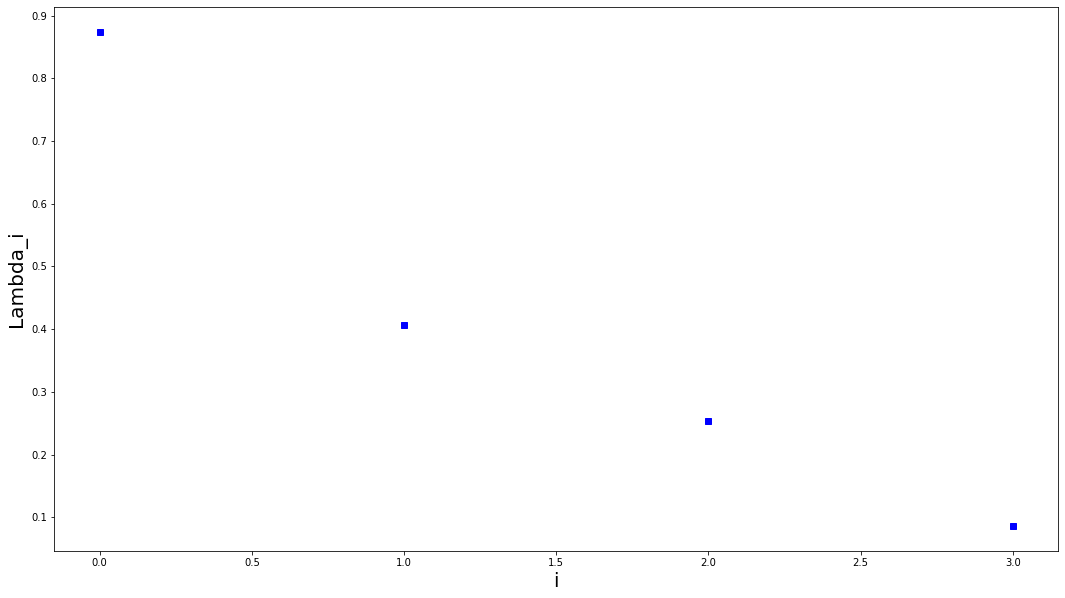

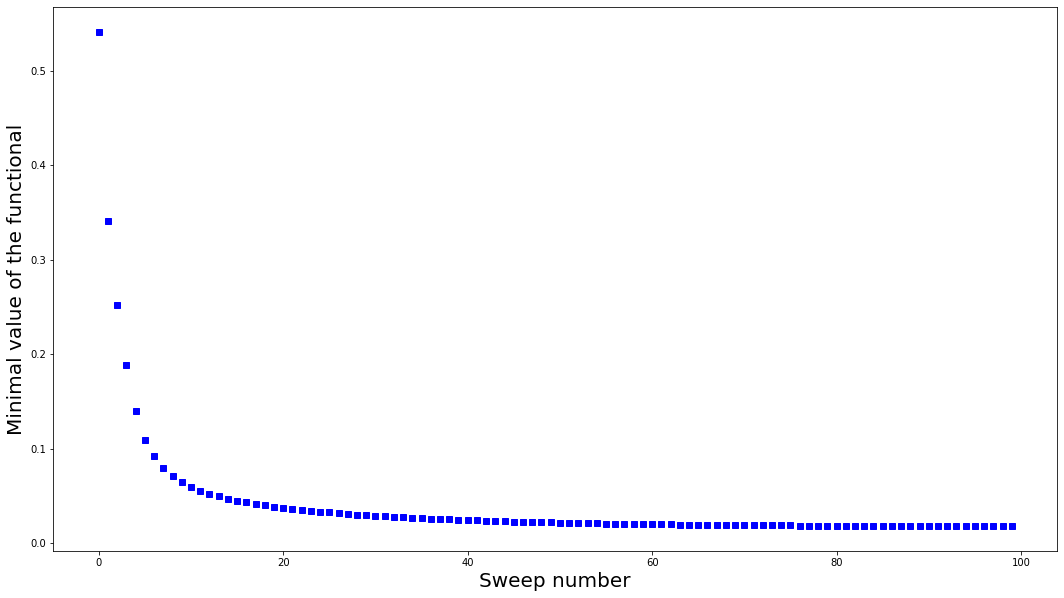

Sweep: 1 of 50, Energy: 0.016131, Bond dim: 8
Sweep: 2 of 50, Energy: 0.015934, Bond dim: 8
Sweep: 3 of 50, Energy: 0.015827, Bond dim: 8
Sweep: 4 of 50, Energy: 0.015744, Bond dim: 8
Sweep: 5 of 50, Energy: 0.015675, Bond dim: 8
Sweep: 6 of 50, Energy: 0.015614, Bond dim: 8
Sweep: 7 of 50, Energy: 0.015523, Bond dim: 8
Sweep: 8 of 50, Energy: 0.015436, Bond dim: 8
Sweep: 9 of 50, Energy: 0.015362, Bond dim: 8
Sweep: 10 of 50, Energy: 0.015301, Bond dim: 8
Sweep: 11 of 50, Energy: 0.015250, Bond dim: 8
Sweep: 12 of 50, Energy: 0.015206, Bond dim: 8
Sweep: 13 of 50, Energy: 0.015168, Bond dim: 8
Sweep: 14 of 50, Energy: 0.015135, Bond dim: 8
Sweep: 15 of 50, Energy: 0.015106, Bond dim: 8
Sweep: 16 of 50, Energy: 0.015079, Bond dim: 8
Sweep: 17 of 50, Energy: 0.015056, Bond dim: 8
Sweep: 18 of 50, Energy: 0.015034, Bond dim: 8
Sweep: 19 of 50, Energy: 0.015015, Bond dim: 8
Sweep: 20 of 50, Energy: 0.014997, Bond dim: 8
Sweep: 21 of 50, Energy: 0.014980, Bond dim: 8
Sweep: 22 of 50, Energ

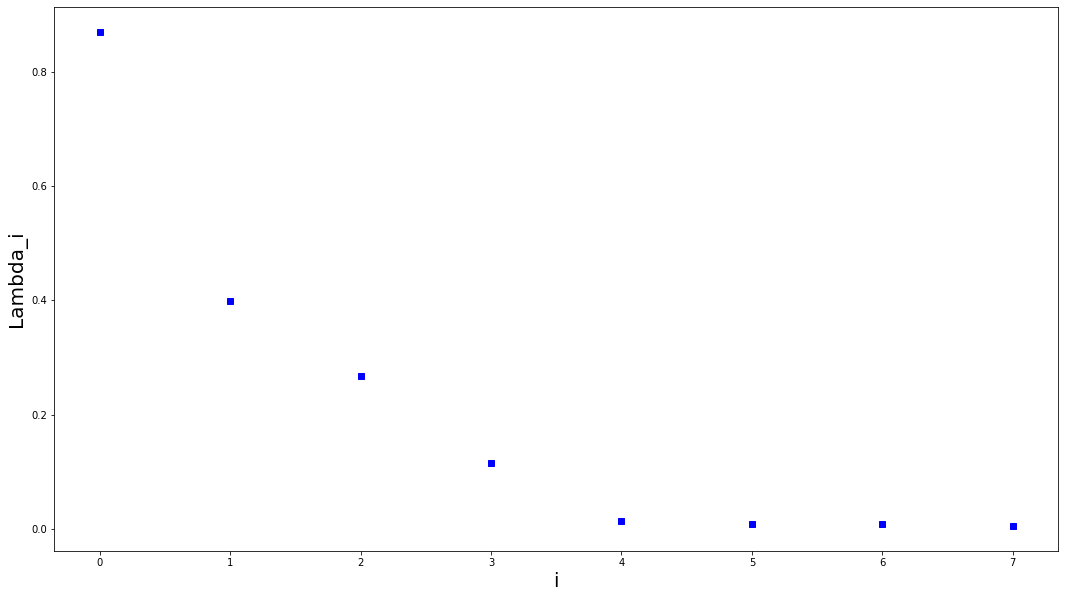

Sweep: 1 of 50, Energy: 0.014813, Bond dim: 8
Sweep: 2 of 50, Energy: 0.014812, Bond dim: 8
Sweep: 3 of 50, Energy: 0.014811, Bond dim: 8
Sweep: 4 of 50, Energy: 0.014810, Bond dim: 8
Sweep: 5 of 50, Energy: 0.014809, Bond dim: 8
Sweep: 6 of 50, Energy: 0.014808, Bond dim: 8
Sweep: 7 of 50, Energy: 0.014807, Bond dim: 8
Sweep: 8 of 50, Energy: 0.014806, Bond dim: 8
Sweep: 9 of 50, Energy: 0.014805, Bond dim: 8
Sweep: 10 of 50, Energy: 0.014805, Bond dim: 8
Sweep: 11 of 50, Energy: 0.014804, Bond dim: 8
Sweep: 12 of 50, Energy: 0.014803, Bond dim: 8
Sweep: 13 of 50, Energy: 0.014803, Bond dim: 8
Sweep: 14 of 50, Energy: 0.014802, Bond dim: 8
Sweep: 15 of 50, Energy: 0.014801, Bond dim: 8
Sweep: 16 of 50, Energy: 0.014801, Bond dim: 8
Sweep: 17 of 50, Energy: 0.014800, Bond dim: 8
Sweep: 18 of 50, Energy: 0.014800, Bond dim: 8
Sweep: 19 of 50, Energy: 0.014799, Bond dim: 8
Sweep: 20 of 50, Energy: 0.014799, Bond dim: 8
Sweep: 21 of 50, Energy: 0.014799, Bond dim: 8
Sweep: 22 of 50, Energ

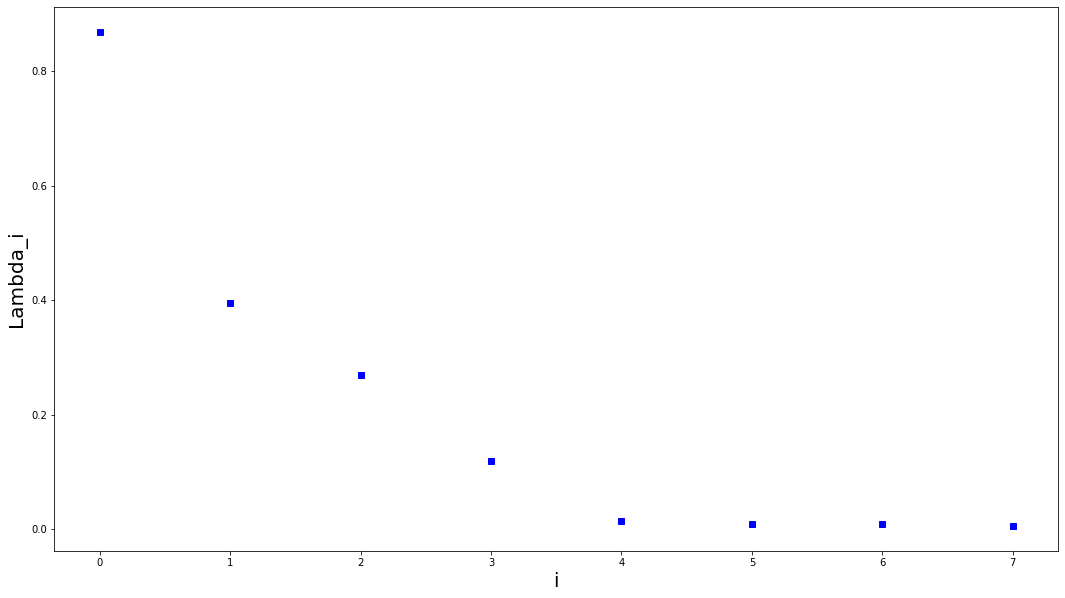

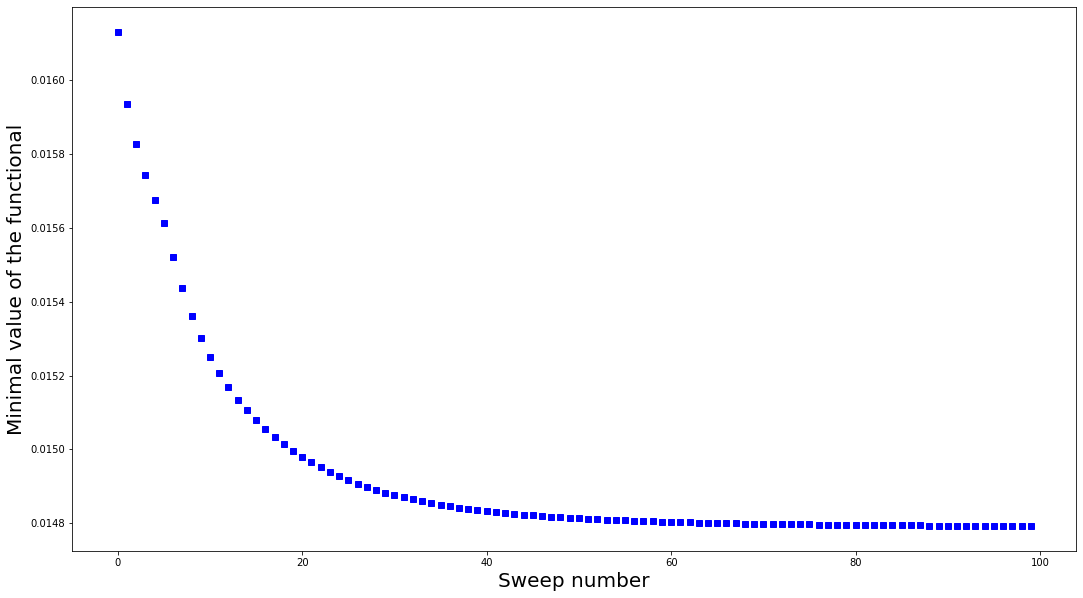

Sweep: 1 of 50, Energy: 0.013087, Bond dim: 16
Sweep: 2 of 50, Energy: 0.012697, Bond dim: 16
Sweep: 3 of 50, Energy: 0.012526, Bond dim: 16
Sweep: 4 of 50, Energy: 0.012424, Bond dim: 16
Sweep: 5 of 50, Energy: 0.012351, Bond dim: 16
Sweep: 6 of 50, Energy: 0.012292, Bond dim: 16
Sweep: 7 of 50, Energy: 0.012243, Bond dim: 16
Sweep: 8 of 50, Energy: 0.012199, Bond dim: 16
Sweep: 9 of 50, Energy: 0.012160, Bond dim: 16
Sweep: 10 of 50, Energy: 0.012125, Bond dim: 16
Sweep: 11 of 50, Energy: 0.012094, Bond dim: 16
Sweep: 12 of 50, Energy: 0.012065, Bond dim: 16
Sweep: 13 of 50, Energy: 0.012039, Bond dim: 16
Sweep: 14 of 50, Energy: 0.012015, Bond dim: 16
Sweep: 15 of 50, Energy: 0.011993, Bond dim: 16
Sweep: 16 of 50, Energy: 0.011972, Bond dim: 16
Sweep: 17 of 50, Energy: 0.011952, Bond dim: 16
Sweep: 18 of 50, Energy: 0.011934, Bond dim: 16
Sweep: 19 of 50, Energy: 0.011917, Bond dim: 16
Sweep: 20 of 50, Energy: 0.011900, Bond dim: 16
Sweep: 21 of 50, Energy: 0.011885, Bond dim: 16
S

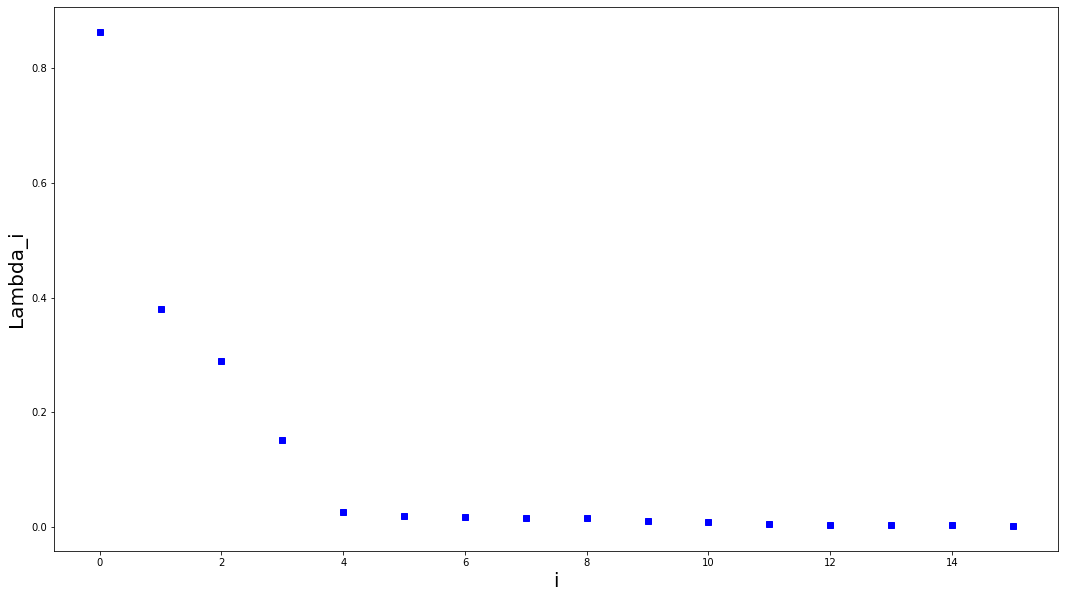

Sweep: 1 of 50, Energy: 0.011622, Bond dim: 16
Sweep: 2 of 50, Energy: 0.011615, Bond dim: 16
Sweep: 3 of 50, Energy: 0.011610, Bond dim: 16
Sweep: 4 of 50, Energy: 0.011604, Bond dim: 16
Sweep: 5 of 50, Energy: 0.011599, Bond dim: 16
Sweep: 6 of 50, Energy: 0.011595, Bond dim: 16
Sweep: 7 of 50, Energy: 0.011591, Bond dim: 16
Sweep: 8 of 50, Energy: 0.011587, Bond dim: 16
Sweep: 9 of 50, Energy: 0.011583, Bond dim: 16
Sweep: 10 of 50, Energy: 0.011579, Bond dim: 16
Sweep: 11 of 50, Energy: 0.011575, Bond dim: 16
Sweep: 12 of 50, Energy: 0.011571, Bond dim: 16
Sweep: 13 of 50, Energy: 0.011568, Bond dim: 16
Sweep: 14 of 50, Energy: 0.011565, Bond dim: 16
Sweep: 15 of 50, Energy: 0.011562, Bond dim: 16
Sweep: 16 of 50, Energy: 0.011559, Bond dim: 16
Sweep: 17 of 50, Energy: 0.011557, Bond dim: 16
Sweep: 18 of 50, Energy: 0.011554, Bond dim: 16
Sweep: 19 of 50, Energy: 0.011552, Bond dim: 16
Sweep: 20 of 50, Energy: 0.011550, Bond dim: 16
Sweep: 21 of 50, Energy: 0.011547, Bond dim: 16
S

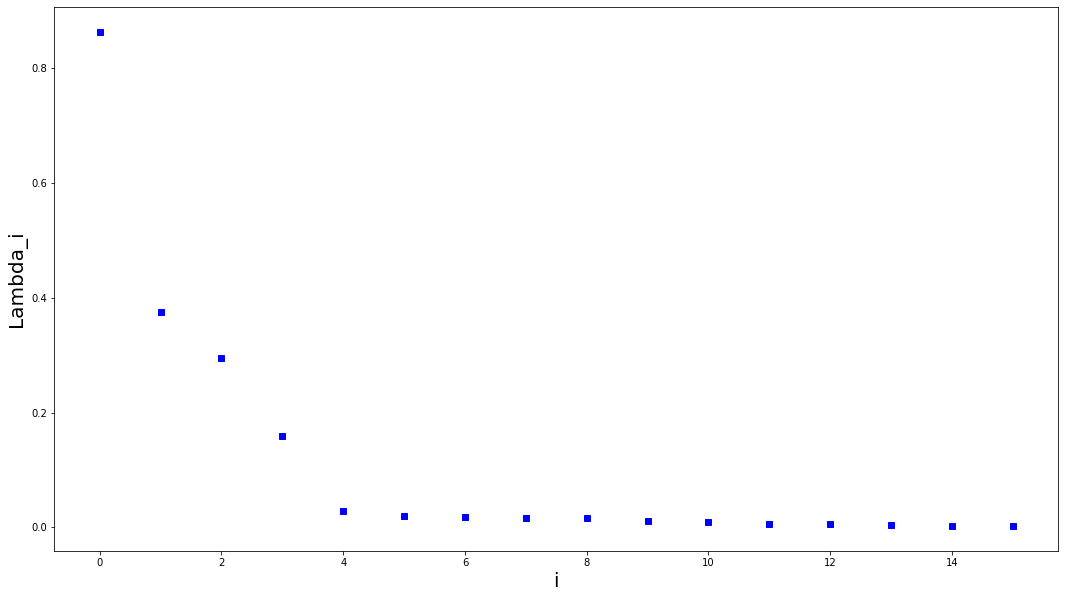

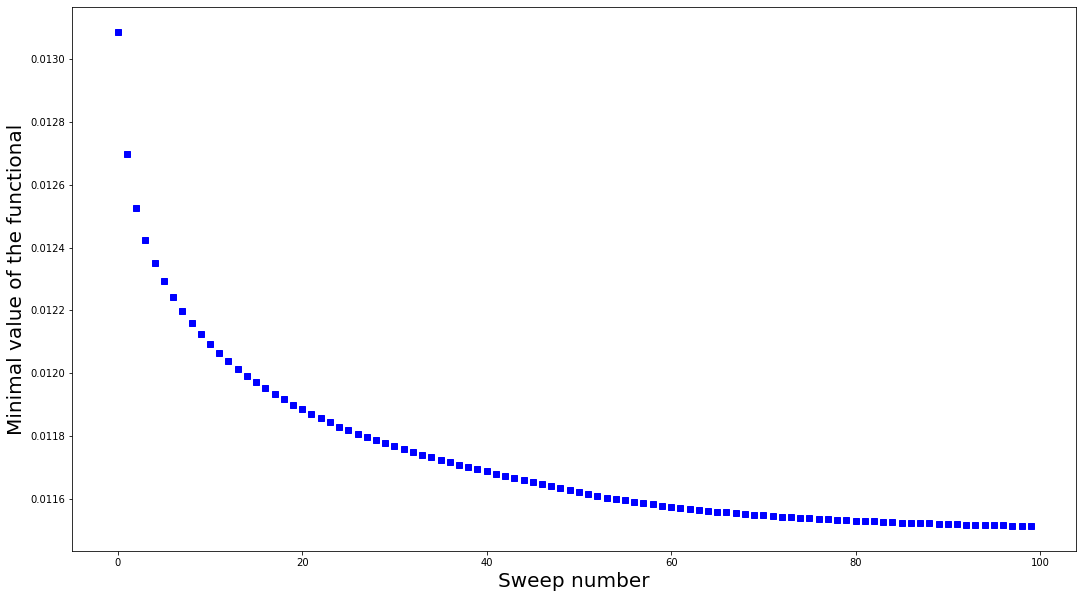

Mininimal value of the functional
0.011513327467020433

peak memory: 200.45 MiB, increment: 16.98 MiB
CPU times: user 23min 43s, sys: 14.5 s, total: 23min 58s
Wall time: 12min 12s


In [123]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 4
N = 20
#print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 50 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 50

#printentrhdensmatr()

#printentrlocdensmatr()


h = 0.1
%time %memit CalculateEnergy()
#h = 0.1
#CalculateEnergy()
#h = 0.7
#CalculateEnergy()